# Policy iteration on Gymnasium environment

In [1]:
!pip install gymnasium
!apt-get install x11-utils
!pip install pyglet
!apt-get install -y xvfb python-opengl
!pip install gym pyvirtualdisplay
!apt-get install xvfb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxkbfile1 libxtst6 libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libfontenc1 libxkbfile1 libxtst6 libxxf86dga1 x11-utils
0 upgraded, 5 newly installed, 0 to remove and 18 not upgraded.
Need to get 318 kB of archives.
After this operation, 1,053 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxtst6 amd64 2:1.2.3-1build4 [13.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxxf86dga1 amd64 2:1.1.5-0ubuntu3 [12.6 kB]
Get:5 http://arch

In [2]:
import random

import numpy as np
import gymnasium as gym
import time
from gymnasium import spaces
import os

from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import matplotlib.pyplot as plt

In [3]:
ENV_SIZE = 5
START_STATE = (0,0)
END_STATE = (ENV_SIZE-1, ENV_SIZE-1)
DIRECTIONS = np.array([
            [0,-1], #LEFT
            [1,0], #DOWN
            [0,1], #RIGHT
            [-1,0], #UP
        ])

In [4]:
env_map = generate_random_map(size=ENV_SIZE)
OBSTACLES = np.zeros((ENV_SIZE,ENV_SIZE))
for row_idx, row in enumerate(env_map):
  for col_idx, state in enumerate(row):
    if state == 'H':
      OBSTACLES[row_idx][col_idx] = 1
print(env_map)
print(OBSTACLES)

['SFFFF', 'FFFFF', 'FFFFH', 'FFFFF', 'FHFFG']
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [5]:
# is_slippery=True means that the transition function is stochastic
env = gym.make('FrozenLake-v1', desc=env_map, is_slippery=False, render_mode='rgb_array')

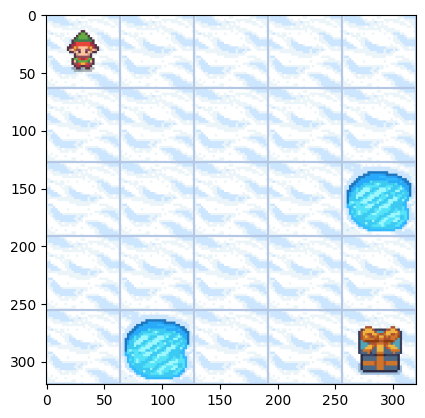

In [6]:
env.reset()
render = env.render()
plt.imshow(render)

In [7]:
def reward_function(s):
    r = 0.0
    if (s == END_STATE).all():
        r = 1

    return r

def reward_probabilities(env):
    rewards = np.zeros((env.observation_space.n))
    i = 0
    for r in range(ENV_SIZE):
        for c in range(ENV_SIZE):
            state = np.array([r,c], dtype=np.uint8)
            rewards[i] = reward_function(state)
            i+=1

    return rewards

In [8]:
# Deterministic transition function
def transition_function(s, a):
    s_prime = s + DIRECTIONS[a,:]

    if s_prime[0] < ENV_SIZE and s_prime[1] < ENV_SIZE and (s_prime >= 0).all():
        if OBSTACLES[s_prime[0], s_prime[1]] == 0 :
            return s_prime

    return s

def transition_probabilities(env, s, a):
    prob_next_state = np.zeros((ENV_SIZE, ENV_SIZE))
    s_prime = transition_function(s, a)

    prob_next_state[s_prime[0], s_prime[1]] = 1.0

    return prob_next_state

In [9]:
def policy_iteration(env, gamma=0.99, max_iters=100, theta=1e-3):
    # rename to policy
    policy = np.random.randint(0, env.action_space.n, (env.observation_space.n))
    print(policy)
    values = np.random.random((env.observation_space.n))
    STATES = np.zeros((env.observation_space.n, 2), dtype=np.uint8)
    REWARDS = reward_probabilities(env)
    env.reset()
    print(REWARDS)
    i = 0
    for r in range(ENV_SIZE):
        for c in range(ENV_SIZE):
            state = np.array([r, c], dtype=np.uint8)
            STATES[i] = state
            i += 1
    for i in range(max_iters):
        # policy evaluation
        while True:
          delta = 0
          for s in range(env.observation_space.n):
              state = STATES[s]
              v_old = values[s]
              # deterministic policy, so no need for weighted sum over actions
              a = policy[s]
              next_state_prob = transition_probabilities(env, state, a).flatten()
              done = (state == END_STATE).all()
              # TODO
              values[s] = (1-done)*(next_state_prob*(REWARDS + gamma*values)).sum()
              # TODO
              delta = max(delta, np.abs(v_old - values[s]))
          if delta < theta:
              break
        # policy improvement
        policy_stable = True
        old_policy = policy.copy()
        for s in range(env.observation_space.n):
            state = STATES[s]
            b = policy[s] # save old best action
            # compute new best action based on the updated value
            best_value = -float('inf')
            best_action = None
            for a in range(env.action_space.n):
                # TODO
                next_state_prob = transition_probabilities(env, state, a).flatten()
                va = (next_state_prob*(REWARDS + gamma*values)).sum()
                if va > best_value:
                    best_value = va
                    best_action = a
            policy[s] = best_action
            if best_action != b:
                policy_stable = False
        if policy_stable:
            break
    print(f'finished in {i+1} iterations')
    return policy.reshape((ENV_SIZE, ENV_SIZE)), values.reshape((ENV_SIZE, ENV_SIZE))

In [10]:
best_actions, values = policy_iteration(env)

print(best_actions)
print(values)

[0 0 1 0 3 1 2 2 1 0 0 2 0 0 3 3 2 0 3 1 3 2 3 3 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
finished in 8 iterations
[[1 1 1 1 0]
 [1 1 1 1 0]
 [1 1 1 1 1]
 [2 2 1 1 1]
 [3 2 2 2 1]]
[[0.93206535 0.94148015 0.95099005 0.96059601 0.95099005]
 [0.94148015 0.95099005 0.96059601 0.970299   0.96059601]
 [0.95099005 0.96059601 0.970299   0.9801     0.99      ]
 [0.96059601 0.970299   0.9801     0.99       1.        ]
 [0.95099005 0.9801     0.99       1.         0.        ]]


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Actions sequence: [1, 1, 1, 2, 2, 1, 2, 2]


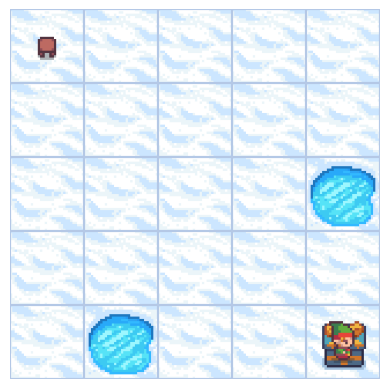

In [11]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gymnasium.utils.save_video import save_video

display = Display(visible=0, size=(400, 300))
display.start()

frames_list = []
done = False

state, _ = env.reset()
i = state // ENV_SIZE
j = state % ENV_SIZE
state = (i,j)
print(state)

prev_screen = env.render()
plt.imshow(prev_screen)
plt.axis('off')

frames_list.append(prev_screen)

actions = []

while not done:
    action = best_actions[state[0],state[1]]
    actions.append(action)

    state, reward, terminated, truncated, _ = env.step(action)
    i = state // ENV_SIZE
    j = state % ENV_SIZE
    state = (i,j)

    done = terminated or truncated

    screen = env.render()
    plt.imshow(screen)
    plt.axis('off')
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    frames_list.append(screen)

ipythondisplay.clear_output(wait=True)

save_video(
        frames_list,
        "videos",
        fps=env.metadata["render_fps"],
    )

env.close()
print(f'Actions sequence: {actions}')